### Importing Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

### Defining helper functions

In [5]:
def get_pearson_coeff(data: pd.DataFrame, var1: str, var2: str):
    coeff = data[[var1, var2]].corr().iloc[0,1]
    return coeff

def get_plot_bw_features(data: pd.DataFrame, var1: str, var2: str):
    x = data[var1]
    y = data[var2]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)

    plt.title(f'Scatter plot of {var1} vs. {var2}')
    plt.xlabel(f'{var1} Concentration')
    plt.ylabel(f'{var2} Concentration')
    plt.show()
    
def kfold_indices(data: pd.DataFrame, k: int):
    fold_size = len(data) // k
    indices = np.arange(len(data))
#     np.random.shuffle(indices)
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

def calculate_metrics(y_true: np.array, y_pred: np.array):
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    true_negatives = np.sum((y_pred == 0) & (y_true == 0))
    false_positives = np.sum((y_pred == 1) & (y_true == 0))
    false_negatives = np.sum((y_pred == 0) & (y_true == 1))
    
    accuracy = (true_positives + true_negatives) / len(y_true)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1

## Programming Questions

### a) Data Processing
     
     1. Downloading and reading the data

In [6]:
train_data_path = 'data_train.csv'
train_data_raw = pd.read_csv(train_data_path)

test_data_path = "data_test.csv"
test_data_raw = pd.read_csv(test_data_path)

    2. Print the first 5 rows of the data using the command. Print the shape of the training dataframe. Write a short description of the data.

In [7]:
print(f"\nFirst 5 rows of the training data:\n\n{train_data_raw.head()}\n\n\nShape of the training data: {train_data_raw.shape}\n\n\n")
print(f"First 5 rows of the test data:\n\n{test_data_raw.head()}\n\n\nShape of the test data: {test_data_raw.shape}\n")


First 5 rows of the training data:

   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  


Shape of the training data: (6250, 13)



First 5 rows of the test data:

### Short description of dataset:
This dataset comprises hourly averaged measurements from various sensors aimed at monitoring air quality and environmental conditions. Variables include concentrations of Non Methane Hydrocarbons, Benzene, NOx, and NO2, alongside sensor responses to these pollutants, indicating their levels in micrograms per cubic meter or parts per billion. Additionally, it captures atmospheric conditions such as temperature, relative humidity, and absolute humidity. The target variable is the sensor response to Carbon Monoxide (CO), signifying its concentration as a primary indicator of air pollution levels. This data is crucial for studying air quality trends, evaluating pollution sources, and developing strategies for environmental protection and public health improvement.

### Variables in dataset:
- **NMHC(GT):** Hourly average of Non Methane Hydrocarbons concentration (μg/m³).
- **C6H6(GT):** Hourly average Benzene concentration (μg/m³).
- **PT08.S2(NMHC):** Hourly average sensor response to NMHC.
- **NOx(GT):** Hourly average NOx concentration (ppb).
- **PT08.S3(NOx):** Hourly average sensor response to NOx.
- **NO2(GT):** Hourly average NO2 concentration (μg/m³).
- **PT08.S4(NO2):** Hourly average sensor response to NO2.
- **PT08.S5(O3):** Hourly average sensor response to O3.
- **T:** Temperature (°C).
- **RH:** Relative Humidity (%).
- **AH:** Absolute Humidity (g/m³).
- **PT08.S1(CO):** TARGET - Hourly average sensor response to CO.

    3. Does the data have any missing values? How many are missing? Return the number of missing values.

In [8]:
missing_training_data = train_data_raw.isnull().sum()
print("Number of missing values in each column of training data:")
print(missing_training_data)

Number of missing values in each column of training data:
Unnamed: 0        0
PT08.S1(CO)      77
NMHC(GT)         77
C6H6(GT)         77
PT08.S2(NMHC)    77
NOx(GT)          77
PT08.S3(NOx)     77
NO2(GT)          77
PT08.S4(NO2)     77
PT08.S5(O3)      77
T                77
RH               77
AH               77
dtype: int64


From the output above, we can see that all the variables have 77 missing values in training data.

In [9]:
missing_test_data = test_data_raw.isnull().sum()
print("Number of missing values in each column of test data:")
print(missing_test_data)

Number of missing values in each column of test data:
Unnamed: 0        0
NMHC(GT)         37
C6H6(GT)         37
PT08.S2(NMHC)    37
NOx(GT)          37
PT08.S3(NOx)     37
NO2(GT)          37
PT08.S4(NO2)     37
PT08.S5(O3)      37
T                37
RH               37
AH               37
dtype: int64


From the output above, we can see that all the variables have 37 missing values in test data.

    4. Drop all the rows with any missing data.

In [10]:
# Drop rows with any missing data in the training DataFrame
train_data_raw.dropna(inplace=True)
print(f"After removing rows with missing data, the shape of the training data is: {train_data_raw.shape}")

# Drop rows with any missing data in the testing DataFrame
test_data_raw.dropna(inplace=True)
print(f"After removing rows with missing data, the shape of the testing data is: {test_data_raw.shape}")

After removing rows with missing data, the shape of the training data is: (6173, 13)
After removing rows with missing data, the shape of the testing data is: (3184, 12)


    5. Extract the features and the label. The label is PT08.S1(CO).

In [11]:
# Separating features and label in the training data:

# Dropping 'PT08.S1(CO)' and 'Unnamed: 0' columns to isolate the features
X_train_raw = train_data_raw.drop(['PT08.S1(CO)', 'Unnamed: 0'], axis=1)

# Isolating 'PT08.S1(CO)' as the label for prediction
y_train_raw = train_data_raw[['PT08.S1(CO)']]

# Displaying the first few rows of features and labels to verify the correct separation and to preview the data
print("\nFeatures Preview:\n")
print(X_train_raw.head())
print(f"\n\nTraining Features shape (rows, columns): {X_train_raw.shape}\n\n\n")
print("\nLabel Preview:\n")
print(y_train_raw.head())
print(f"\n\nTraining Label shape (rows, columns): {y_train_raw.shape}\n")


Features Preview:

   NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  \
0    -200.0       2.1          593.0    146.0        1212.0     72.0   
1    -200.0      11.0         1013.0    354.0         545.0    141.0   
2    -200.0       7.6          882.0    342.0         885.0    149.0   
3    -200.0      18.1         1243.0    481.0         599.0    173.0   
4    -200.0       7.3          869.0     71.0         953.0     77.0   

   PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0         984.0        494.0  10.8  49.7  0.6429  
1        1384.0       1287.0  17.4  50.6  0.9989  
2         950.0        894.0   7.8  33.9  0.3594  
3        1815.0       1582.0  26.4  41.9  1.4237  
4        1363.0        632.0  37.4  14.7  0.9295  


Training Features shape (rows, columns): (6173, 11)




Label Preview:

   PT08.S1(CO)
0        797.0
1       1282.0
2        891.0
3       1285.0
4        892.0


Training Label shape (rows, columns): (6173, 1)



In [12]:
# Preparing the test features by dropping the 'Unnamed: 0' column from the test DataFrame
X_test_raw = test_data_raw.drop('Unnamed: 0', axis=1)

# Displaying the first few rows of the test features to give a preview and verify that the column has been successfully removed
print("\nTest Features Preview after removing unwanted (unnamed) column:\n")
print(X_test_raw.head())

# Printing the shape of the test features DataFrame to provide information on the number of observations and features ready for testing
print(f"\n\nTest features shape (rows, columns): {X_test_raw.shape}\n")



Test Features Preview after removing unwanted (unnamed) column:

   NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  \
0    -200.0       8.0          898.0    122.0         933.0    105.0   
1    -200.0      19.4         1281.0   -200.0         774.0   -200.0   
2    -200.0       9.9          975.0    349.0         638.0    223.0   
3    -200.0      12.7         1075.0    103.0         749.0     98.0   
4    -200.0       2.9          647.0    131.0        1054.0     85.0   

   PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1594.0       1098.0  17.0  51.7  0.9914  
1        1952.0       1324.0  20.8  43.6  1.0614  
2        1243.0       1064.0   5.6  74.6  0.6826  
3        1690.0       1022.0  31.7  21.5  0.9902  
4         962.0        828.0   8.4  54.5  0.6022  


Test features shape (rows, columns): (3184, 11)



### b) Exploratory Data Analysis:

            1. Plot the histograms of all the features in the data. Do all the features have a normal distribution? Do you see any outlier values? Do you need to apply any normalization technique to these values? If so, you can transform your data in this step and explain your thought process in the corresponding markdown cell.

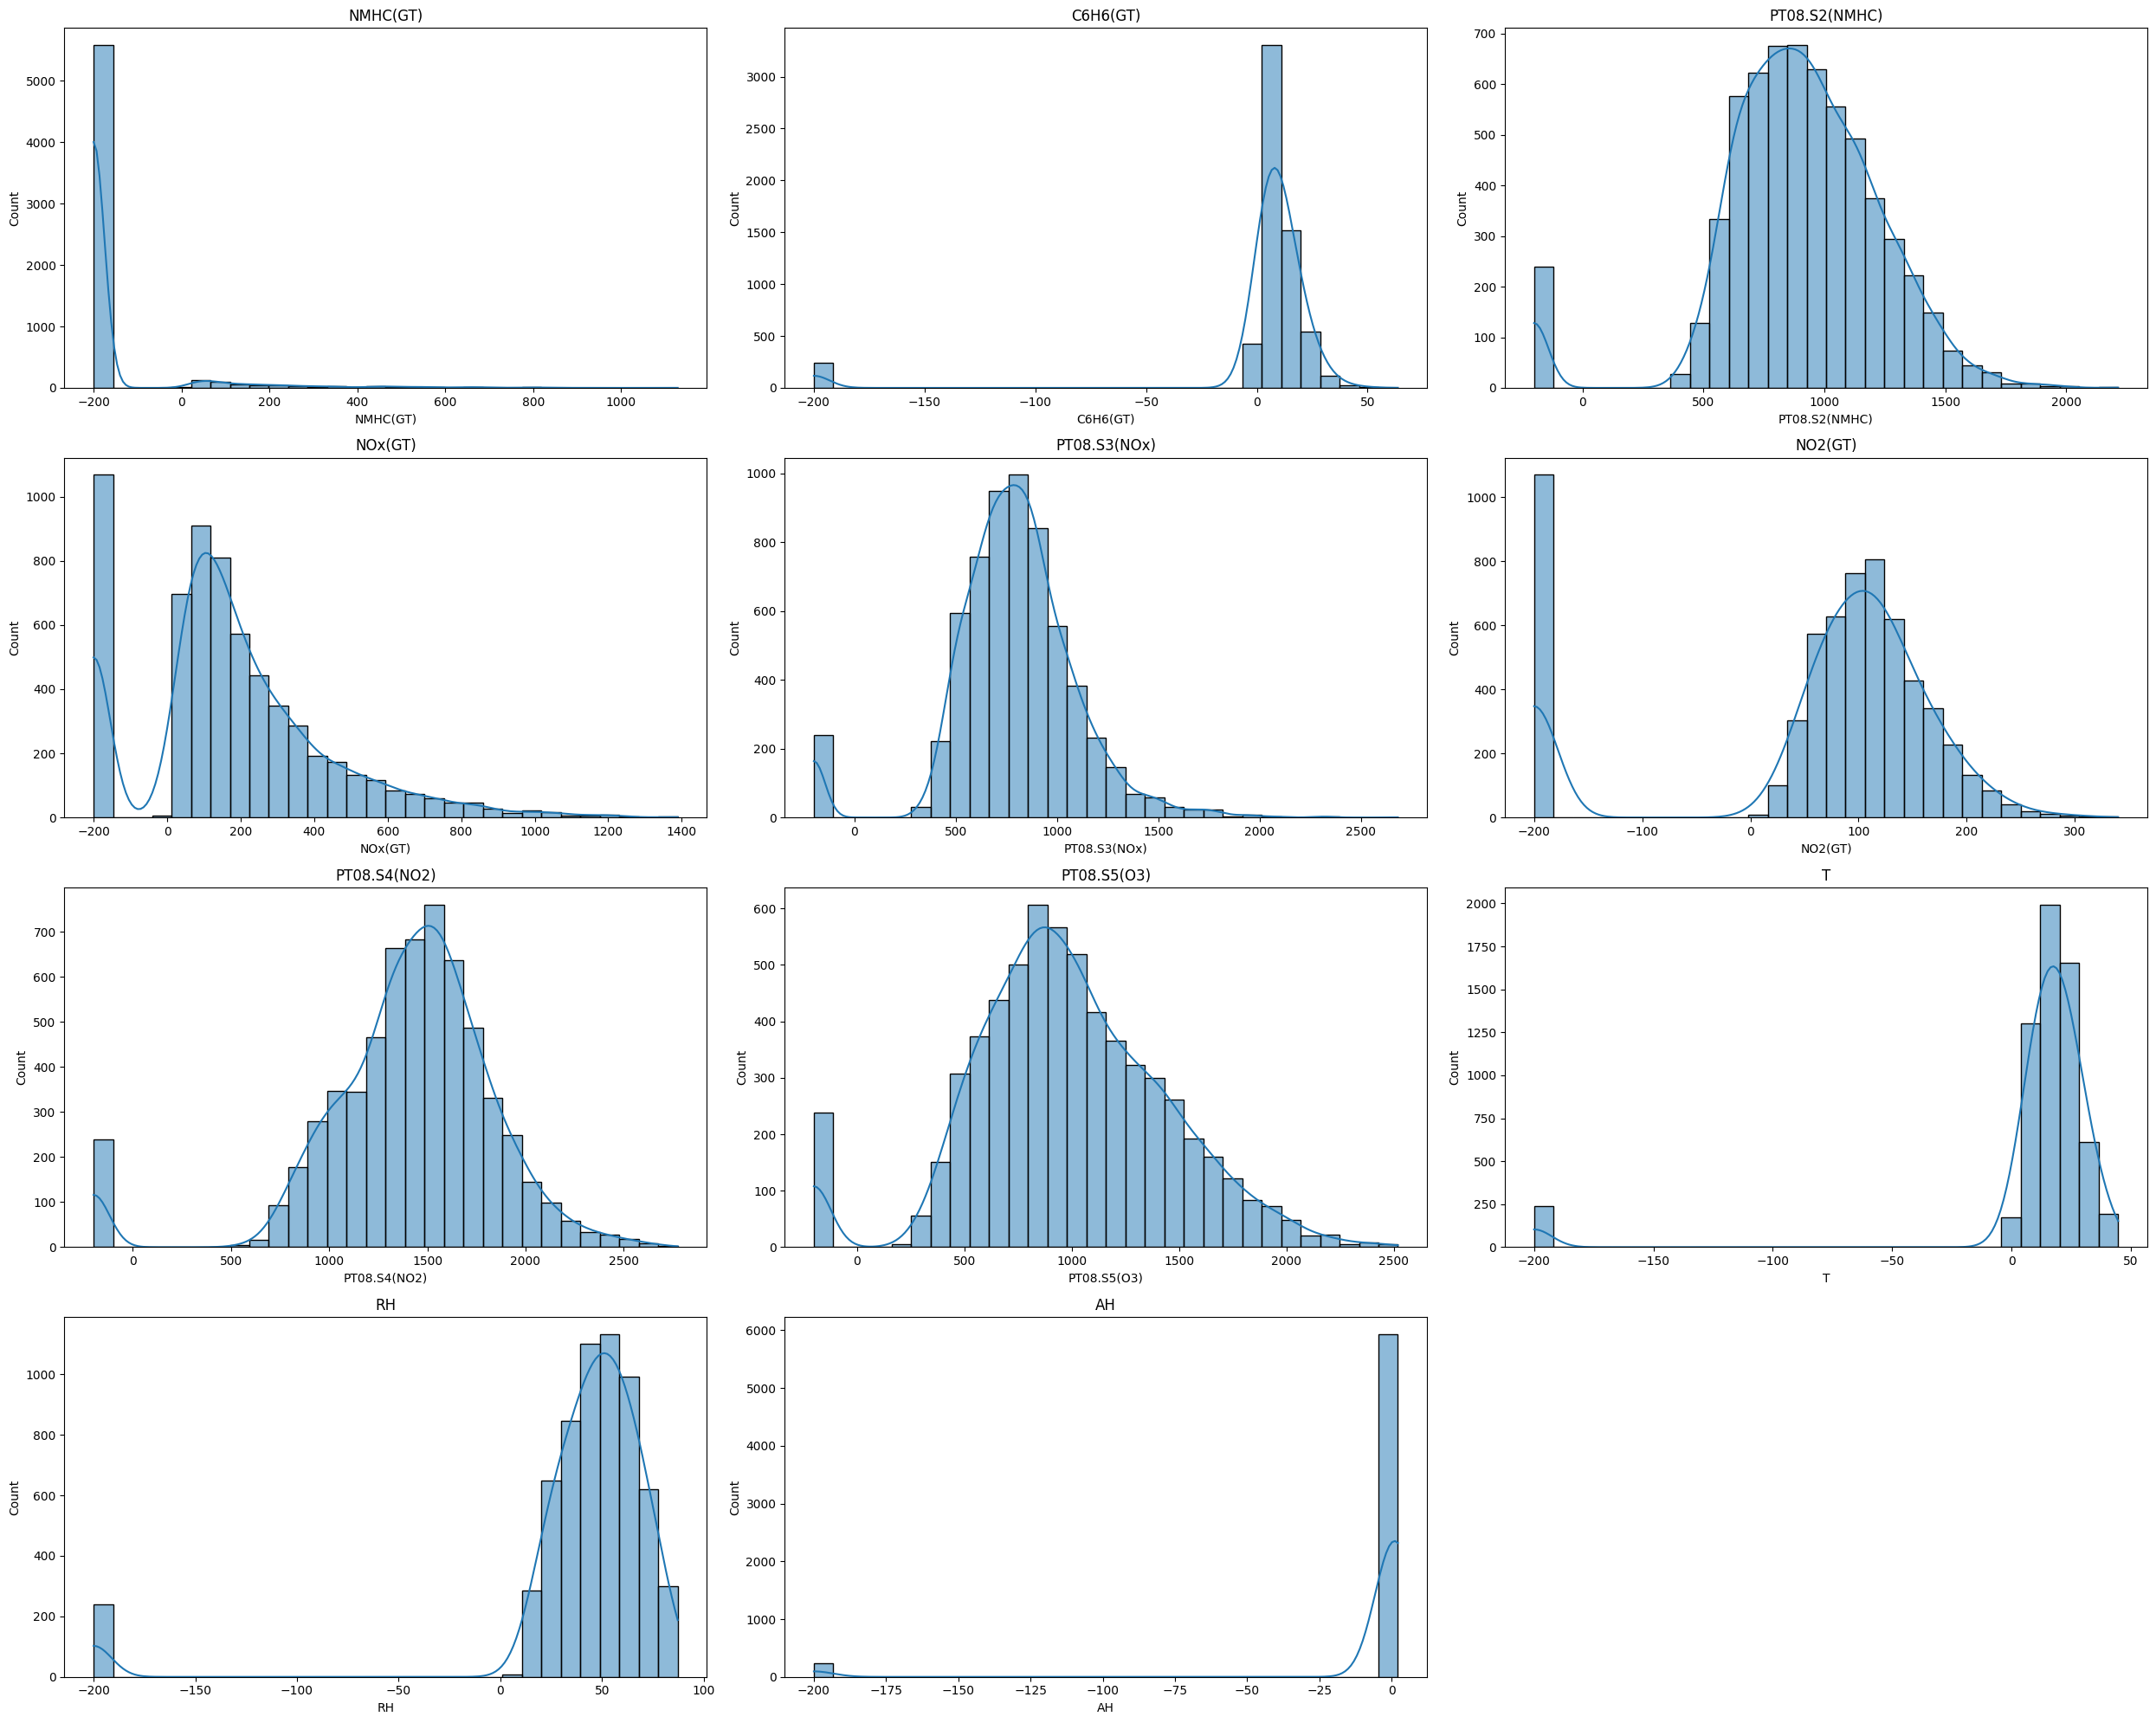

In [13]:
plt.figure(figsize=(25,20))
for i, column in enumerate(X_train_raw.columns[0:],1):
    plt.subplot(4,3,i)
    sns.histplot(X_train_raw[column], kde = True, bins = 30)
    plt.title(column)
    
plt.tight_layout()
plt.show()

#### Do all the features have a normal distribution? 
The histograms reveal that not all features exhibit a normal distribution. Features with a bell-shaped curve are indicative of a normal distribution, whereas those that are skewed to the left or right, have multiple peaks, or do not follow the bell shape, do not have a normal distribution. From the visual inspection above, it's clear that several features have skewed distributions or do not exhibit the characteristics of a normal distribution.

#### Do you see any outlier values?
Yes, the presence of outlier values can be inferred from the histograms. Features with bars (bins) that are significantly separated from the rest of the data distribution or those that have a long tail extending far from the central mass of the data suggest the presence of outliers. Specifically, the placeholder value of -200 used in all features acts as an outlier and indicates missing or anomalous data.
    
#### Do you need to apply any normalization technique to these values?
Given the skewed distributions and presence of outliers, applying normalization techniques would be beneficial for many machine learning models that assume data is normally distributed or at least not heavily skewed. Normalization can help in making the training process more stable and faster converging. Techniques such as Min-Max scaling, Standardization (Z-score normalization), or transformations like logarithmic, square root, or Box-Cox can be used to address skewness and reduce the impact of outliers.

#### If so, you can transform your data in this step and explain your thought process in the corresponding markdown cell.
In response to the observation of skewed distribution among the variables in my dataset, I opted to implement Min-Max scaling using sklearn's preprocessing tools. This approach is designed to normalize the data, adjusting all values to fall within a 0 to 1 scale. My decision was driven by the need to ensure that all variables are on a common scale, thereby facilitating more effective analysis and modeling. By standardizing the range of the features, I aimed to mitigate the potential impact of outliers and enhance the performance of algorithms that are sensitive to the scale of input data. This preprocessing step is crucial for models that rely on distance calculations, as it ensures that no single feature will dominate the outcome due to its scale. Through this method, I am confident in creating a more balanced dataset that is suitable for the subsequent phases of my analysis.


### Data Transformation using Min-Max Scaling from sklearn.preprocessing:

In [14]:
# Normalize training features using Min-Max scaling
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_raw)

# Convert normalized features back to a DataFrame for ease of use
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train_raw.columns)
X_train_normalized_df.head()

,NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.0,0.766401,0.328500,0.217747,0.489768,0.503704,0.397983,0.255241,0.861815,0.869429,0.992394
1,0.0,0.800152,0.502486,0.348647,0.258411,0.631481,0.532437,0.546892,0.888798,0.872563,0.994155
2,0.0,0.787258,0.448219,0.341095,0.376344,0.646296,0.386555,0.402354,0.849550,0.814415,0.990992
3,0.0,0.827076,0.597763,0.428571,0.277142,0.690741,0.677311,0.655388,0.925593,0.842270,0.996256
4,0.0,0.786121,0.442833,0.170548,0.399931,0.512963,0.525378,0.305995,0.970564,0.747563,0.993812


In [15]:
# Normalize testing features using Min-Max scaling
X_test_normalized = scaler.fit_transform(X_test_raw)

# Convert normalized features back to a DataFrame for ease of use
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test_raw.columns)
X_test_normalized_df.head()

,NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.0,0.829346,0.502978,0.191781,0.410656,0.572233,0.608961,0.476680,0.892637,0.871839,0.993870
1,0.0,0.874801,0.678424,0.000000,0.353026,0.000000,0.730482,0.559677,0.908268,0.843782,0.994217
2,0.0,0.836922,0.538250,0.326980,0.303733,0.793621,0.489817,0.464194,0.845742,0.951160,0.992343
3,0.0,0.848086,0.584059,0.180465,0.343965,0.559099,0.641548,0.448770,0.953106,0.767232,0.993864
4,0.0,0.809011,0.387998,0.197141,0.454513,0.534709,0.394433,0.377525,0.857260,0.881538,0.991946


Following the application of Min-Max scaling to normalize the dataset, I proceeded to revisit the histogram plots for each feature. This step was crucial to visually confirm that the transformation was successful, ensuring all features now fall within the desired range of 0 to 1. 

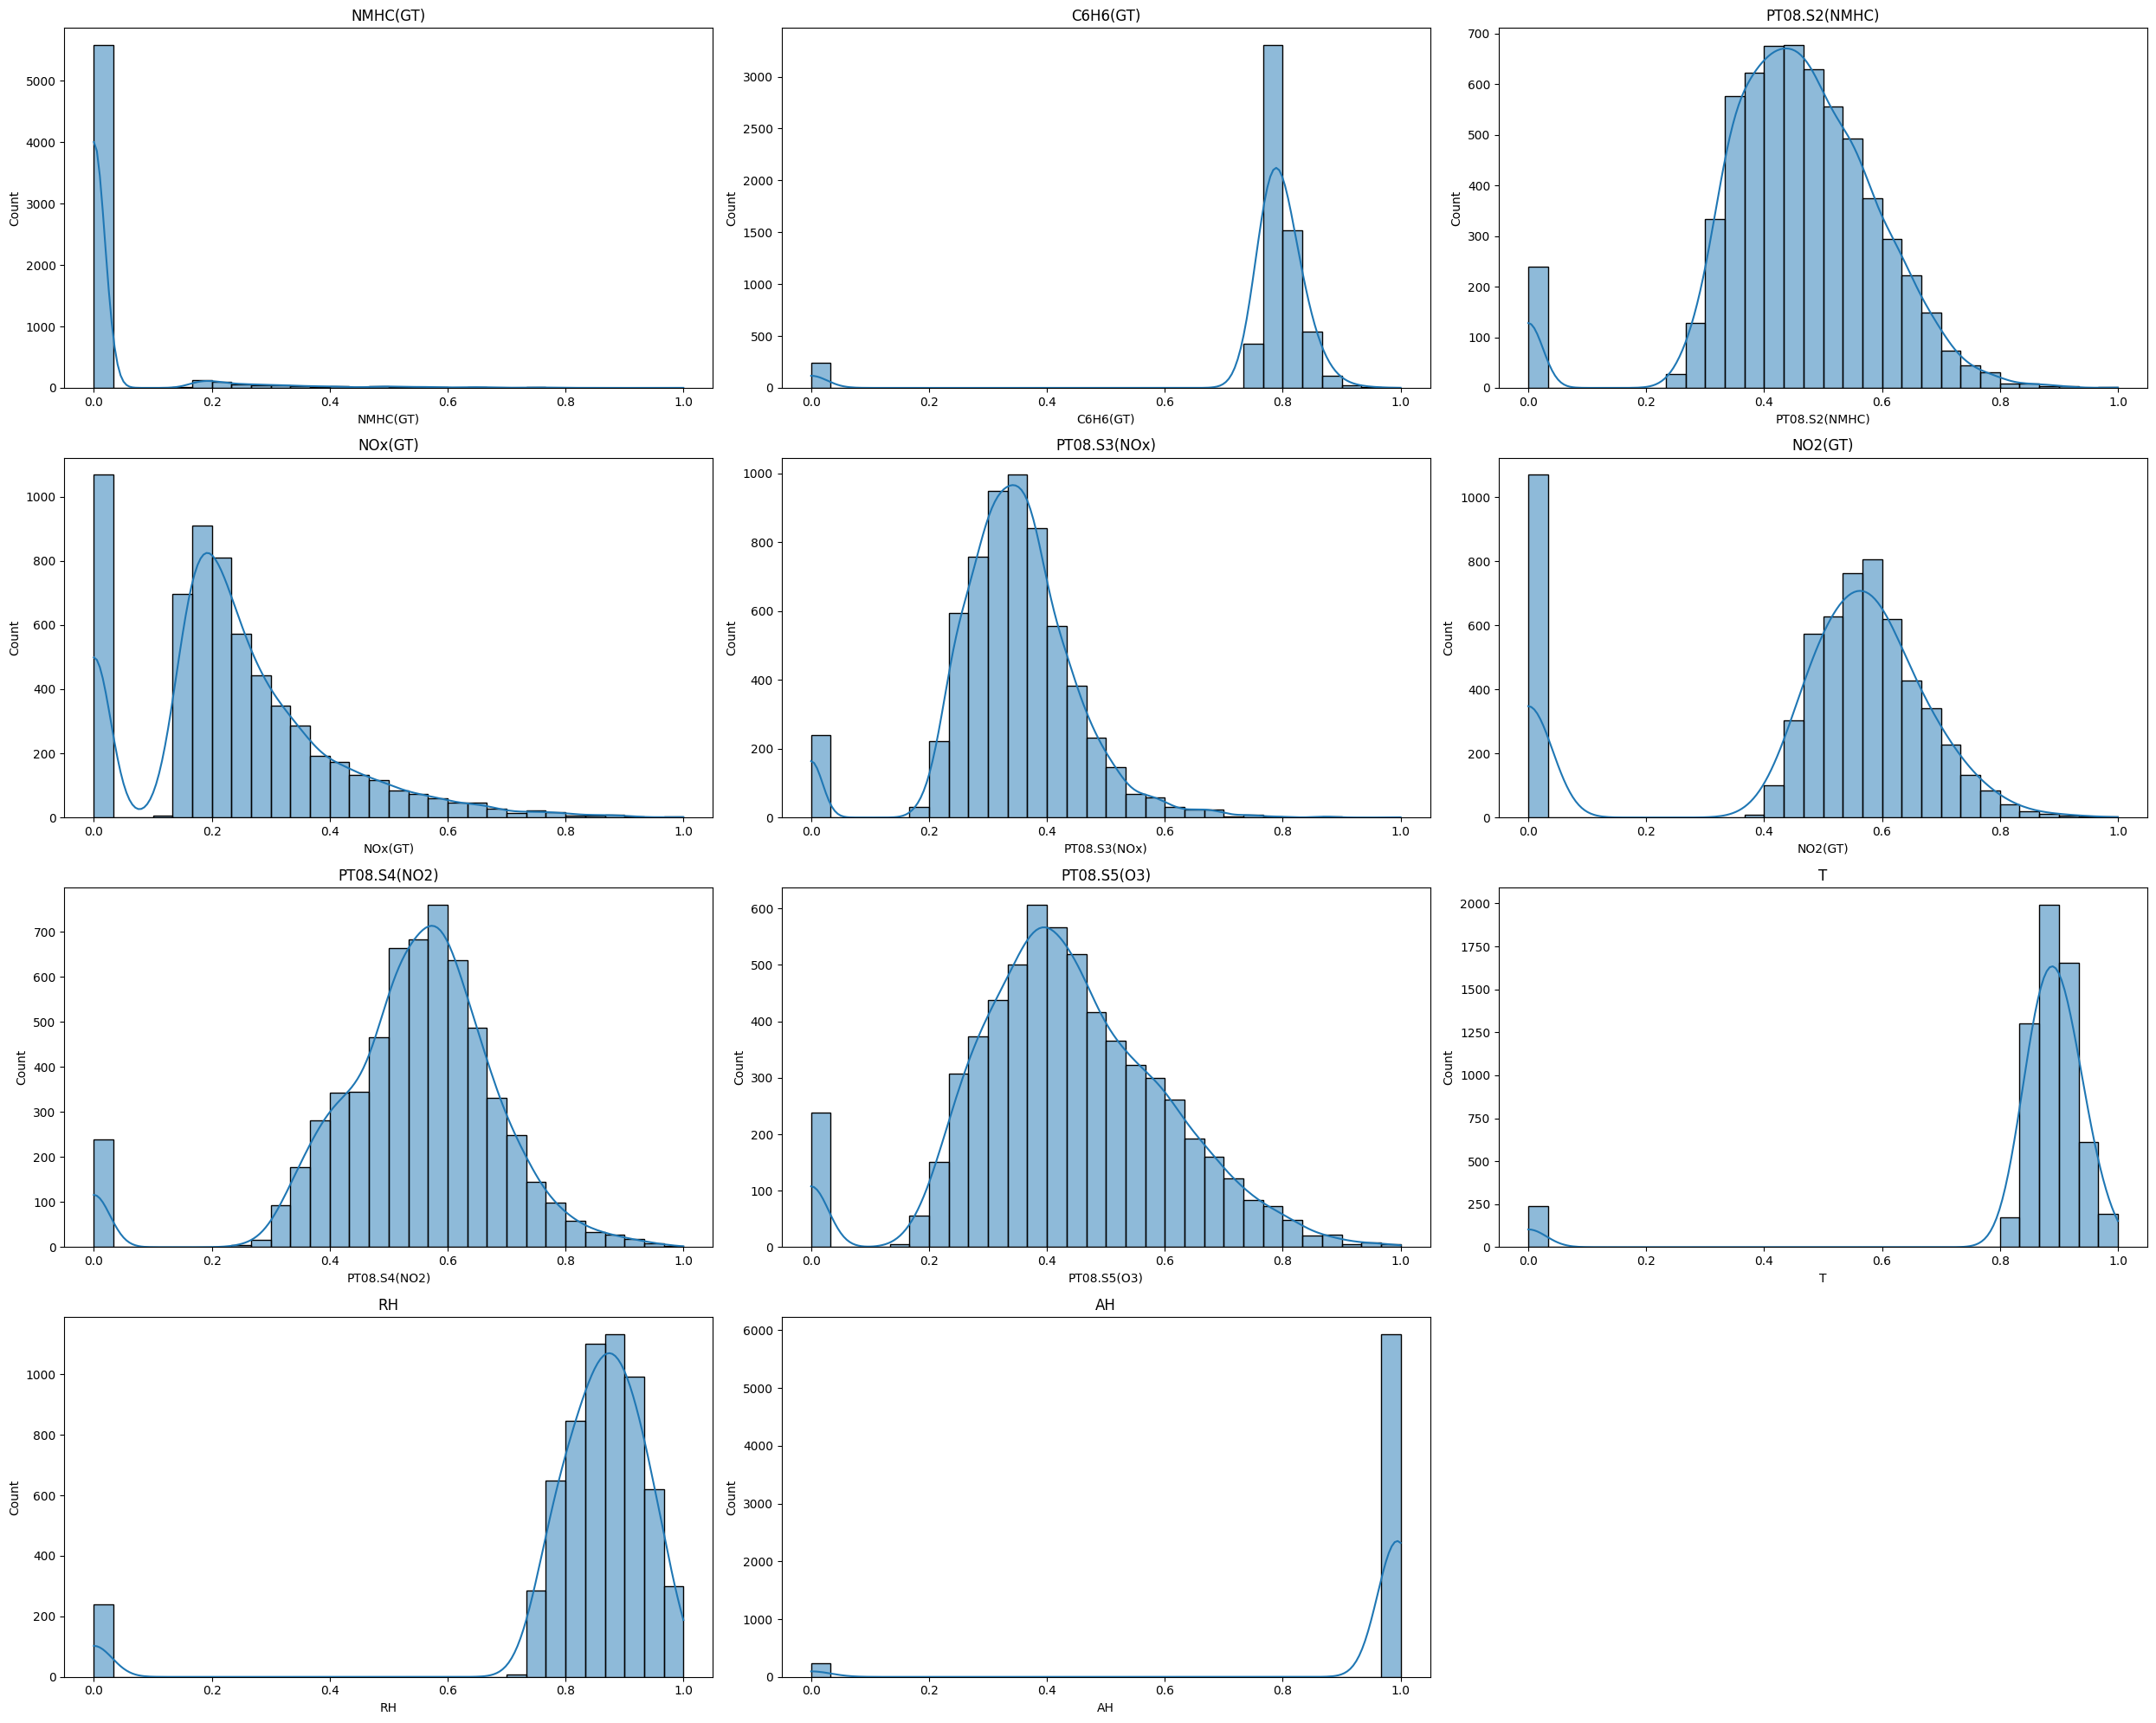

In [16]:
plt.figure(figsize=(25,20))
for i, column in enumerate(X_train_normalized_df.columns[0:],1):
    plt.subplot(4,3,i)
    sns.histplot(X_train_normalized_df[column], kde = True, bins = 30)
    plt.title(column)
    
plt.tight_layout()
plt.show()

By ensuring that each feature is scaled appropriately, I am better positioned to leverage the data for insightful analyses and robust predictive modeling.

    2. Pick 2 features and create a scatter plot to illustrate the correlation between these two features. Is there a high correlation between these features?

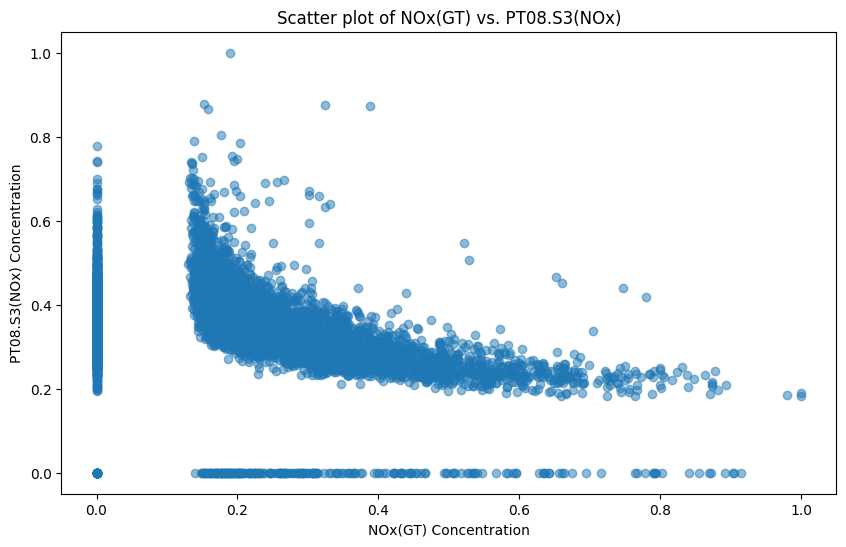

Pearson's correlation coefficient:
 -0.4495740466503582


In [17]:
# Example features - replace these with your actual feature column names
feature1 = 'NOx(GT)'
feature2 = 'PT08.S3(NOx)'

get_plot_bw_features(data=X_train_normalized_df, var1= feature1, var2 = feature2)

# Calculating Pearson's correlation coefficient
correlation_coefficient = get_pearson_coeff(X_train_normalized_df, feature1, feature2)
print("Pearson's correlation coefficient:\n", correlation_coefficient)



Two features have been selected for analysis: NOx(GT) and PT08.S3(NOx). A scatter plot has been created to visualize the correlation between these two features. From the scatter plot, we observe that as the concentration of NOx(GT) increases, the sensor readings of PT08.S3(NOx) tend to decrease. This indicates a negative correlation between the two variables.

The Pearson correlation coefficient is a statistical measure of the strength of a linear relationship between two variables. It ranges from -1 to 1, where 1 means a perfect positive correlation, 0 means no correlation, and -1 means a perfect negative correlation.

The calculated Pearson's correlation coefficient, as seen above, is approximately -0.4495740466503582. This value suggests a moderate negative correlation between NOx(GT) and PT08.S3(NOx). The negative value indicates an inverse relationship, which is clearly visible in the scatter plot as well.

    3. Compute the Pearson’s correlation between all pairs of variables 1-12. Assign the resulting correlation values in a 12x12 matrix C, whose (i; j) element represents the correlation value between variables i and j, i.e., C(i; j) = corr(i; j). Visualize the resulting matrix C with a heatmap and discuss potential associations between the considered variables.

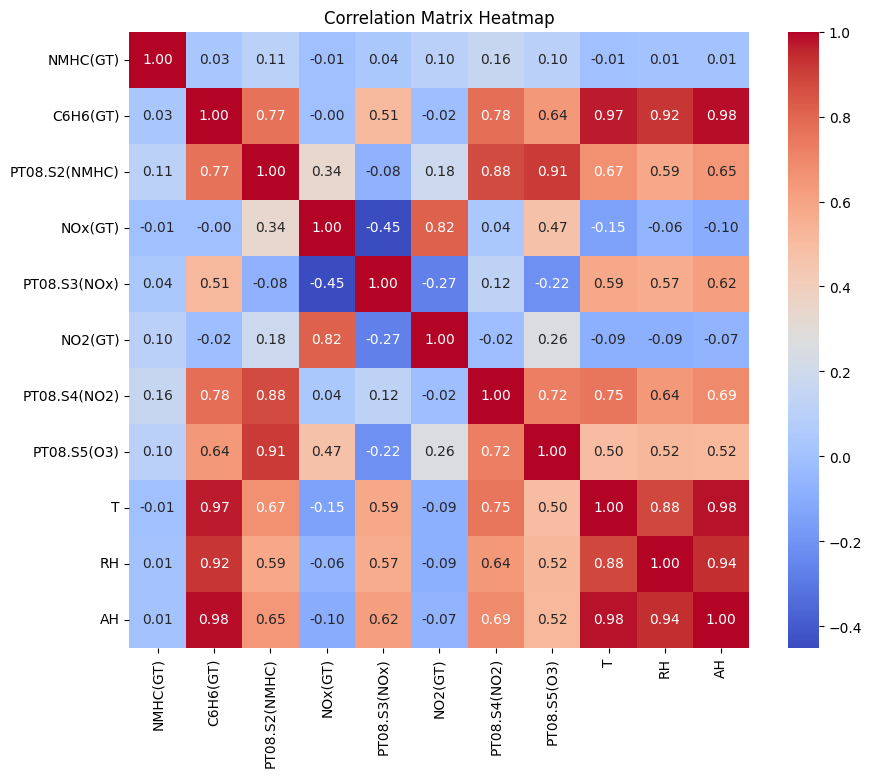

In [18]:
# Compute the correlation matrix for all the variables
C = X_train_normalized_df.corr()  

# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(C, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

The heatmap visualization of matrix C clearly shows the varying degrees of correlation through a color spectrum ranging from blue (negative correlation) to red (positive correlation). The strength of the correlation is indicated by the intensity of the color, with the scale provided on the right side of the heatmap.

##### Potential associations:
- Variables such as C6H6(GT) and AH exhibit a very strong positive correlation (~0.98), suggesting that when the value of C6H6(GT) increases, the value of AH also increases proportionally, and vice versa.
- NO2(GT) and NOx(GT) also display a strong positive correlation (0.82).
- On the other hand, PT08.S4(NO2) shows a moderate negative correlation with NO2(GT) (-0.27), indicating an inverse relationship between these two variables.
- Some variables like T (temperature) and RH (relative humidity) have a significant positive correlation with AH (absolute humidity), with coefficients of 0.98 and 0.94 respectively, suggesting that higher temperatures and relative humidity levels are associated with higher absolute humidity levels.

### c) Linear Regression Implementation:

In [19]:
class SimpleLinearRegressor:
    """
    A simple linear regression model that fits a straight line to the data.
    
    Attributes:
        coefficients (np.ndarray): The coefficients (weights) of the linear regression model,
                                   including both the intercept and the slope.
    """
    def __init__(self):
        """
        Initializes the SimpleLinearRegressor with no intercept and no weights.
        """  
        self.coeff = None
        self.intercept = None
        self.weights = None

    def __add_intercept(self, X: np.ndarray) -> np.ndarray:
        """
        Adds an intercept term to the input feature matrix.

        Args:
            X (np.ndarray): The input feature matrix.

        Returns:
            np.ndarray: The modified input feature matrix with an added intercept term.
        """
        intercept = np.ones((X.shape[0], 1))  # Create an intercept term of ones
        X_with_intercept = np.hstack((intercept, X))  # Add intercept term to the input features

        return X_with_intercept
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Fits the linear regression model to the training data.

        Args:
            X_train (np.ndarray): The input features for training.
            y_train (np.ndarray): The target values for training.

        Returns:
            None
        """
        X_b = self.__add_intercept(X_train)  # Add intercept term to input features

        # Compute the coefficients using the Normal Equation
        X_b_T = X_b.T
        self.coeff = np.linalg.inv(X_b_T.dot(X_b)).dot(X_b_T).dot(y_train)
        self.intercept = self.coeff[0]
        self.weights = self.coeff[1:]
        
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Predicts the target values for the given test data.

        Args:
            X_test (np.ndarray): The input features for testing.

        Returns:
            np.ndarray: The predicted target values.
        """
        X_b = self.__add_intercept(X_test) # Add intercept term to input features 

        return X_b.dot(self.coeff)

In [20]:
linear_reg_model = SimpleLinearRegressor()
linear_reg_model.fit(X_train_normalized_df.values, y_train_raw.values)
lin_reg_intercept = linear_reg_model.intercept
lin__reg_weights = linear_reg_model.weights

In [21]:
print(f"\nThe model's intercept (bias) after training is: {lin_reg_intercept.item():.4f}\n")

print("The weights (coefficients) corresponding to each feature are as follows:")
for i, column in enumerate(X_train_normalized_df.columns):
    print(f"{column} ---> {lin__reg_weights[i].item():.4f}")


The model's intercept (bias) after training is: -226.0896

The weights (coefficients) corresponding to each feature are as follows:
NMHC(GT) ---> 293.3125
C6H6(GT) ---> 2063.8515
PT08.S2(NMHC) ---> 111.2739
NOx(GT) ---> 66.3912
PT08.S3(NOx) ---> -410.7539
NO2(GT) ---> -4.4303
PT08.S4(NO2) ---> 215.8217
PT08.S5(O3) ---> 537.8922
T ---> -234.4244
RH ---> 228.3906
AH ---> -600.6544


To find the most informative features using the coefficients of this linear regression model, I would look at the absolute values of the weights assigned to each feature. The higher the absolute value, the more impact that feature has on the model's predictions. For instance, C6H6(GT) has a very high coefficient of *2063.8515*, suggesting it's highly informative for predicting the outcome. On the other hand, NO2(GT) has a very low coefficient of *-4.4303*, indicating it has much less influence on the model's predictions. Features with negative coefficients, like PT08.S3(NOx) and AH, are also informative but in the opposite direction of the positive coefficients. So, by comparing these weights, I can determine which features are most important for the model.

### d) Logistic Regression Implementation:


In [22]:
y_train_transformed= y_train_raw['PT08.S1(CO)'].apply(lambda x:1 if x>1000 else 0)
y_train_log = pd.DataFrame(y_train_transformed, columns=y_train_raw.columns)

In [23]:
import numpy as np

class SimpleLogisticRegressor:
    """
    Custom implementation of Logistic Regression for binary classification.
    
    Attributes:
        learning_rate (float): The step size at each iteration while moving toward a minimum of the cost function.
        num_iterations (int): Number of iterations for gradient descent optimization.
        intercept_ (float): Intercept term of the logistic regression model.
        weights_ (np.ndarray): Coefficients of the features in the logistic regression model.
    """
    
    def __init__(self, learning_rate: float = 1.0, num_iterations: int = 10000) -> None:
        """
        Initializes the logistic regression model with specified learning rate and number of iterations.
        
        Parameters:
            learning_rate (float): Learning rate for optimization.
            num_iterations (int): Number of iterations for the optimization algorithm.
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.coeff_ = None
        self.intercept_ = None
        self.weights_ = None
    
    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        """
        Adds an intercept term to the input feature matrix.

        Args:
            X (np.ndarray): The input feature matrix.

        Returns:
            np.ndarray: The modified input feature matrix with an added intercept term.
        """
        intercept = np.ones((X.shape[0], 1))  # Create an intercept term of ones
        X_with_intercept = np.hstack((intercept, X))  # Add intercept term to the input features

        return X_with_intercept
    
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        """
        Computes the sigmoid function for each element in the input array.
        
        Parameters:
            z (np.ndarray): The input value(s) for the sigmoid function.
            
        Returns:
            np.ndarray: The output of the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))
    
    def _compute_cost(self, h: np.ndarray, y: np.ndarray) -> float:
        """
        Computes the logistic cost function.
        
        Parameters:
            h (np.ndarray): The predicted probabilities.
            y (np.ndarray): The true labels.
            
        Returns:
            float: The cost value.
        """
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fits the logistic regression model to the training data.
        
        Parameters:
            X (np.ndarray): Training data, feature matrix.
            y (np.ndarray): Training data, true label vector.
        """
        XX = self._add_intercept(X)
        self.coeff = np.zeros(XX.shape[1]).reshape(XX.shape[1], -1)
        
        for i in range(self.num_iterations):
            z = np.dot(XX, self.coeff)
            h = self._sigmoid(z)
            gradient = np.dot(XX.T, (h - y)) / y.size
            self.coeff -= self.learning_rate * gradient
            
            if i % 1000 == 0 or i == (self.num_iterations - 1):
                cost = self._compute_cost(h, y)
                print(f'Cost after iteration {i+1}: {cost:.4f}')
                
        self.intercept_ = self.coeff[0]
        self.weights_ = self.coeff[1:]
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts probabilities for the input data.
        
        Parameters:
            X (np.ndarray): Input data for prediction.
            
        Returns:
            np.ndarray: Predicted probabilities for each input sample.
        """
        XX = self._add_intercept(X)
        z = np.dot(XX, self.coeff)
        return self._sigmoid(z)
    
    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Predicts the class labels for the input data based on a specified threshold.
        
        Parameters:
            X (np.ndarray): Input data for prediction.
            threshold (float): The threshold for classifying as 1.
            
        Returns:
            np.ndarray: Predicted class labels for each input sample.
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

In [24]:
log_reg_model = SimpleLogisticRegressor(learning_rate=0.5, num_iterations=10000)
log_reg_model.fit(X_train_normalized_df.values, y_train_log.values)
log_reg_intercept = log_reg_model.intercept_
log_reg_weights = log_reg_model.weights_

Cost after iteration 1: 0.6931


Cost after iteration 1001: 0.2775
Cost after iteration 2001: 0.2487
Cost after iteration 3001: 0.2376
Cost after iteration 4001: 0.2317
Cost after iteration 5001: 0.2280
Cost after iteration 6001: 0.2254
Cost after iteration 7001: 0.2236
Cost after iteration 8001: 0.2222
Cost after iteration 9001: 0.2211
Cost after iteration 10000: 0.2202


In [25]:
print(f"\nThe model's intercept (bias) after training is: {log_reg_intercept.item():.4f}\n")

print("The weights (coefficients) corresponding to each feature are as follows:")
for i, column in enumerate(X_train_normalized_df.columns):
    print(f"{column} ---> {log_reg_weights[i].item():.4f}")


The model's intercept (bias) after training is: -7.0233

The weights (coefficients) corresponding to each feature are as follows:
NMHC(GT) ---> 6.9371
C6H6(GT) ---> 0.7466
PT08.S2(NMHC) ---> 10.8433
NOx(GT) ---> 2.7794
PT08.S3(NOx) ---> -11.2303
NO2(GT) ---> 0.0019
PT08.S4(NO2) ---> 7.0980
PT08.S5(O3) ---> 12.8873
T ---> -3.0048
RH ---> 1.9306
AH ---> -2.2936


### e) Result Analysis - Linear Regression (KFold Cross-Validation):

In [26]:
# Define the number of folds (K)
k = 5

# Get the fold indices
cv_lin_fold_indices = kfold_indices(X_train_normalized_df, k)

fold_rmse_scores = []

for train_index, test_index in cv_lin_fold_indices:
    X_train_cv = X_train_normalized_df.iloc[train_index]
    X_test_cv = X_train_normalized_df.iloc[test_index]
    y_train_cv = y_train_raw.iloc[train_index]
    y_test_cv = y_train_raw.iloc[test_index]
    
    model = SimpleLinearRegressor()
    model.fit(X_train_cv.values, y_train_cv.values) #to get weights
    preds = model.predict(X_test_cv) #to get predictions
    
    rms = np.sqrt(((preds - y_test_cv)**2).mean()).item()
    fold_rmse_scores.append(rms)
    
average_rmse = np.mean(fold_rmse_scores)
std_dev_rmse = np.std(fold_rmse_scores)

In [27]:
for i, rmse in enumerate(fold_rmse_scores):
    print(f"RMSE for fold {i+1} : {rmse:.4f}")

print(f"\nAverage RMSE over all folds: {average_rmse:.4f}")
print(f"\nStd deviation of RMSE over all folds: {std_dev_rmse:.4f}")

RMSE for fold 1 : 70.1242
RMSE for fold 2 : 72.9601
RMSE for fold 3 : 67.9407
RMSE for fold 4 : 72.5266
RMSE for fold 5 : 72.5909

Average RMSE over all folds: 71.2285

Std deviation of RMSE over all folds: 1.9271


### f) Result Analysis - Logistic Regression (KFold Cross-Validation):

In [28]:
# Define the number of folds (K)
k = 5

# Get the fold indices
cv_log_fold_indices = kfold_indices(X_train_normalized_df, k)

accuracies, precisions, recalls, f1_scores = [], [], [], []

for i, (train_index, test_index) in enumerate(cv_log_fold_indices):
    X_train_cv = X_train_normalized_df.iloc[train_index]
    X_test_cv = X_train_normalized_df.iloc[test_index]
    y_train_cv = y_train_log.iloc[train_index]
    y_test_cv = y_train_log.iloc[test_index]
    
    print(f"fold {i+1}:")
    model = SimpleLogisticRegressor(learning_rate=0.5, num_iterations=10000)
    model.fit(X_train_cv.values, y_train_cv.values)
    
    preds = model.predict(X_test_cv.values)
    
    accuracy, precision, recall, f1 = calculate_metrics(y_test_cv.values, preds)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

average_accuracy = np.mean(accuracies)
std_dev_accuracy = np.std(accuracies)

average_precision = np.mean(precisions)
std_dev_precision = np.std(precisions)

average_recall = np.mean(recalls)
std_dev_recall = np.std(recalls)

average_f1 = np.mean(f1_scores)
std_dev_f1 = np.std(f1_scores)

fold 1:
Cost after iteration 1: 0.6931
Cost after iteration 1001: 0.2772
Cost after iteration 2001: 0.2486
Cost after iteration 3001: 0.2376
Cost after iteration 4001: 0.2317
Cost after iteration 5001: 0.2280
Cost after iteration 6001: 0.2255
Cost after iteration 7001: 0.2236
Cost after iteration 8001: 0.2222
Cost after iteration 9001: 0.2210
Cost after iteration 10000: 0.2201
fold 2:
Cost after iteration 1: 0.6931
Cost after iteration 1001: 0.2797
Cost after iteration 2001: 0.2509
Cost after iteration 3001: 0.2397
Cost after iteration 4001: 0.2336
Cost after iteration 5001: 0.2298
Cost after iteration 6001: 0.2273
Cost after iteration 7001: 0.2254
Cost after iteration 8001: 0.2239
Cost after iteration 9001: 0.2228
Cost after iteration 10000: 0.2219
fold 3:
Cost after iteration 1: 0.6931
Cost after iteration 1001: 0.2780
Cost after iteration 2001: 0.2494
Cost after iteration 3001: 0.2384
Cost after iteration 4001: 0.2326
Cost after iteration 5001: 0.2290
Cost after iteration 6001: 0.22

In [29]:
for i, accuracy in enumerate(accuracies):
    print(f"Accuracy for fold {i+1} : {accuracy:.4f}")

print(f"\nAverage Accuracy over all folds: {average_accuracy:.4f}")
print(f"\nStd deviation of Accuracy over all folds: {std_dev_accuracy:.4f}")

Accuracy for fold 1 : 0.9125
Accuracy for fold 2 : 0.9157
Accuracy for fold 3 : 0.8995
Accuracy for fold 4 : 0.8874
Accuracy for fold 5 : 0.9028

Average Accuracy over all folds: 0.9036

Std deviation of Accuracy over all folds: 0.0101


In [30]:
for i, precision in enumerate(precisions):
    print(f"Precision for fold {i+1} : {precision:.4f}")

print(f"\nAverage Precision over all folds: {average_precision:.4f}")
print(f"\nStd deviation of Precision over all folds: {std_dev_precision:.4f}")

Precision for fold 1 : 0.9171
Precision for fold 2 : 0.9343
Precision for fold 3 : 0.9129
Precision for fold 4 : 0.9072
Precision for fold 5 : 0.9123

Average Precision over all folds: 0.9167

Std deviation of Precision over all folds: 0.0093


In [31]:
for i, recall in enumerate(recalls):
    print(f"Recall for fold {i+1} : {recall:.4f}")

print(f"\nAverage Recall over all folds: {average_recall:.4f}")
print(f"\nStd deviation of Recall over all folds: {std_dev_recall:.4f}")

Recall for fold 1 : 0.9349
Recall for fold 2 : 0.9269
Recall for fold 3 : 0.9203
Recall for fold 4 : 0.9084
Recall for fold 5 : 0.9315

Average Recall over all folds: 0.9244

Std deviation of Recall over all folds: 0.0094


In [32]:
for i, f1_score in enumerate(f1_scores):
    print(f"F1 score for fold {i+1} : {f1_score:.4f}")

print(f"\nAverage F1 Score over all folds: {average_f1:.4f}")
print(f"\nStd deviation of F1 Score over all folds: {std_dev_f1:.4f}")

F1 score for fold 1 : 0.9259
F1 score for fold 2 : 0.9306
F1 score for fold 3 : 0.9166
F1 score for fold 4 : 0.9078
F1 score for fold 5 : 0.9218

Average F1 Score over all folds: 0.9205

Std deviation of F1 Score over all folds: 0.0079


The changes in accuracy, precision, recall, and F1 score across different folds are relatively small. The standard deviations for accuracy (0.0101), precision (0.0093), recall (0.0094), and F1 score (0.0079) indicate that the variation between different folds is minimal.

This consistency suggests that the trained model is stable and performs similarly across different subsets of the data. It means that the model is likely not overfitting to a specific part of the data and should generalize well to unseen data.

### g) ROC Curve - Logistic Regression:

In [33]:
X = X_train_normalized_df.values
y = y_train_log.values

k = 5
fold_indices = kfold_indices(X_train_normalized_df, k)




Fold 1: 
Cost after iteration 1: 0.6931


Cost after iteration 1001: 0.2772
Cost after iteration 2001: 0.2486
Cost after iteration 3001: 0.2376
Cost after iteration 4001: 0.2317
Cost after iteration 5001: 0.2280
Cost after iteration 6001: 0.2255
Cost after iteration 7001: 0.2236
Cost after iteration 8001: 0.2222
Cost after iteration 9001: 0.2210
Cost after iteration 10000: 0.2201


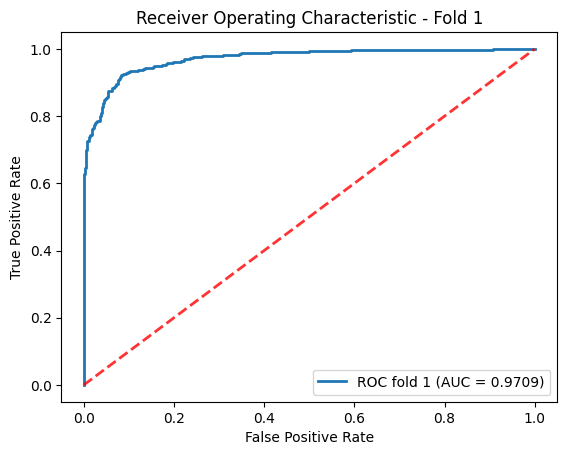




Fold 2: 
Cost after iteration 1: 0.6931
Cost after iteration 1001: 0.2797
Cost after iteration 2001: 0.2509
Cost after iteration 3001: 0.2397
Cost after iteration 4001: 0.2336
Cost after iteration 5001: 0.2298
Cost after iteration 6001: 0.2273
Cost after iteration 7001: 0.2254
Cost after iteration 8001: 0.2239
Cost after iteration 9001: 0.2228
Cost after iteration 10000: 0.2219


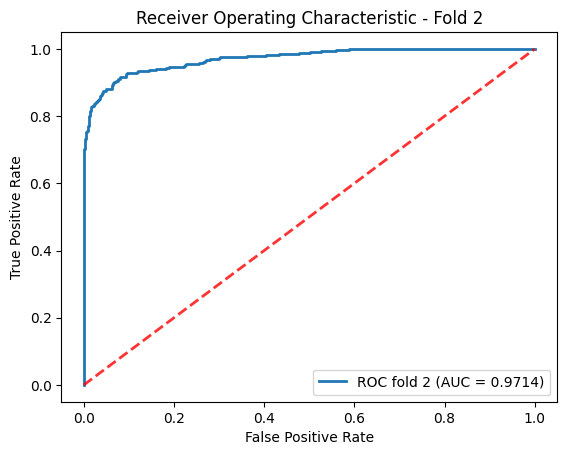




Fold 3: 
Cost after iteration 1: 0.6931
Cost after iteration 1001: 0.2780
Cost after iteration 2001: 0.2494
Cost after iteration 3001: 0.2384
Cost after iteration 4001: 0.2326
Cost after iteration 5001: 0.2290
Cost after iteration 6001: 0.2266
Cost after iteration 7001: 0.2249
Cost after iteration 8001: 0.2236
Cost after iteration 9001: 0.2226
Cost after iteration 10000: 0.2218


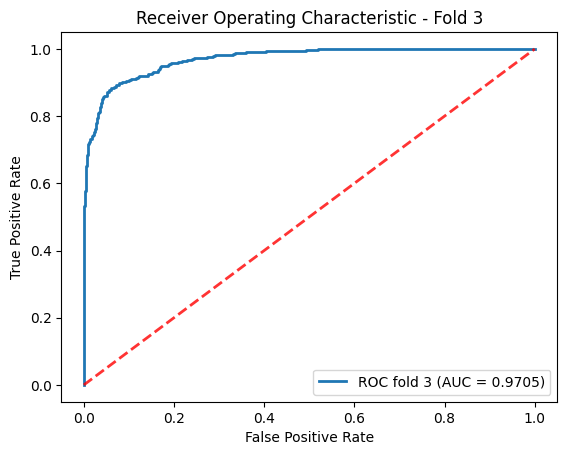




Fold 4: 
Cost after iteration 1: 0.6931
Cost after iteration 1001: 0.2740
Cost after iteration 2001: 0.2453
Cost after iteration 3001: 0.2341
Cost after iteration 4001: 0.2282
Cost after iteration 5001: 0.2245
Cost after iteration 6001: 0.2220
Cost after iteration 7001: 0.2202
Cost after iteration 8001: 0.2189
Cost after iteration 9001: 0.2178
Cost after iteration 10000: 0.2170


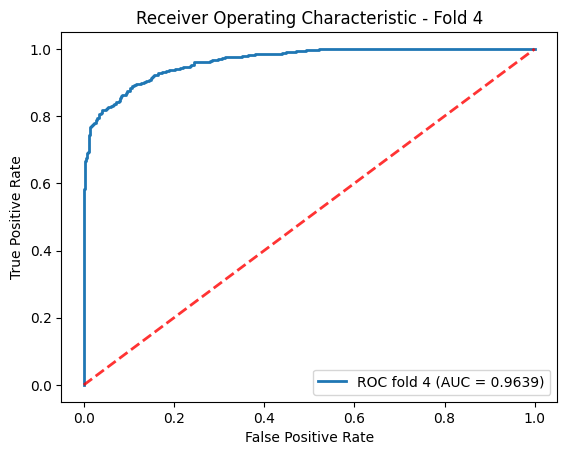




Fold 5: 
Cost after iteration 1: 0.6931
Cost after iteration 1001: 0.2786
Cost after iteration 2001: 0.2494
Cost after iteration 3001: 0.2381
Cost after iteration 4001: 0.2320
Cost after iteration 5001: 0.2282
Cost after iteration 6001: 0.2255
Cost after iteration 7001: 0.2236
Cost after iteration 8001: 0.2222
Cost after iteration 9001: 0.2210
Cost after iteration 10000: 0.2200


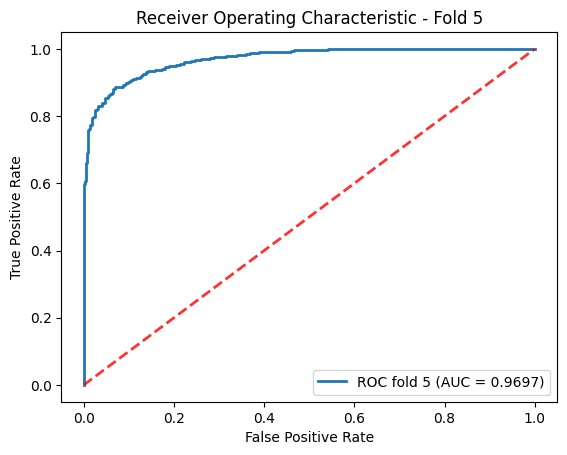

In [34]:
diction = {}
auc_scores = []

# Loop through each fold for plotting individual ROC curves
for i, (train_index, test_index) in enumerate(fold_indices):
    X_train_cv = X_train_normalized_df.iloc[train_index]
    X_test_cv = X_train_normalized_df.iloc[test_index]
    y_train_cv = y_train_log.iloc[train_index]
    y_test_cv = y_train_log.iloc[test_index]
    
    # Using the custom Logistic Regression model
    mod = SimpleLogisticRegressor(learning_rate=0.5, num_iterations=10000)
    print(f"\n\n\nFold {i+1}: ")
    mod.fit(X_train_cv.values, y_train_cv.values)
    
    y_scores = mod.predict_proba(X_test_cv.values)
    fpr, tpr, _ = roc_curve(y_test_cv.values, y_scores)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
    diction[i] = (fpr, tpr)
    
    # Plot ROC for the current fold
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (AUC = %0.4f)' % (i+1, roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic - Fold {i+1}")
    plt.legend(loc="lower right")
    plt.show()


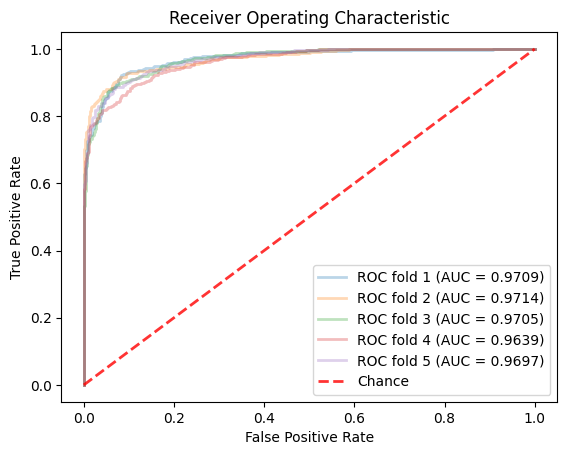

Average AUC: 0.9693, Standard Deviation of AUC: 0.0027


In [35]:
fig, ax = plt.subplots()

for fold, (fpr, tpr) in diction.items():
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (fold+1, auc_scores[fold]))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Calculating and displaying the average and standard deviation of AUC scores
average_auc = np.mean(auc_scores)
std_dev_auc = np.std(auc_scores)
print(f"Average AUC: {average_auc:.4f}, Standard Deviation of AUC: {std_dev_auc:.4f}")


The ROC curves from the 5-fold cross-validation using the logistic regression model show a high and consistent Area Under the Curve (AUC) for each fold, ranging from approximately 0.9639 to 0.9714. These AUC values are high and quite close to each other with a very small standar deviation of 0.0027.

The high AUC values also align well with the other metrics (accuracy, precision, recall, and F1 score), all of which were consistently high. This consistency in the ROC curve analysis and other performance metrics suggests that the logistic regression model is performing well and that the results are reliable.

### h) Inference - Linear and Logistic Regression

    1. Use the trained linear regression model and predict the PT08.S1(CO) value for the test data.

In [36]:
y_pred_test_lin = linear_reg_model.predict(X_test_normalized_df)
y_pred_test_lin_np = np.array(y_pred_test_lin)
y_pred_test_lin_1d = y_pred_test_lin_np.reshape(3184,)

    2. Use the trained logistic regression model and predict the PT08.S1(CO) binary value (the same label you created in step d) for the test data.

In [37]:
y_pred_test_log = log_reg_model.predict(X_test_normalized_df.values)
y_pred_test_log_np = np.array(y_pred_test_log)
y_pred_test_log_1d = y_pred_test_log_np.reshape(3184,)

    3. Save the predictions in a csv file with two main columns. One for the linear regression predictions with the name pred_linear and one for the logistic regression predictions with the name pred_logistic.

In [38]:
predictions_df = pd.DataFrame({
    'pred_linear': y_pred_test_lin_1d,
    'pred_logistic': y_pred_test_log_1d
})

# Save to CSV without the index
predictions_df.to_csv('Air_quality_preds.csv', index=False)